# Introduction

Dans le guide précédent, nous avons terminé la configuration et la configuration de la base de données et lié la base de données au code à l'aide d'ORM. Nous avons ensuite implémenté l'API d'enregistrement des utilisateurs en plus de cela. Ce  guide est divisé en quatre parties. La première partie consiste à authentifier l'utilisateur et à lui permettre de se connecter à sa propre page de profil privé. La deuxième partie complète le système de partage de recettes, permettant aux utilisateurs de publier ou de dépublier leurs recettes. La troisième partie montre comment actualiser le jeton de sécurité et implémenter la fonction de déconnexion. Et enfin, nous parlerons de la façon dont nous pouvons utiliser la fonction de liste noire pour forcer l'utilisateur à se déconnecter. 

L'authentification des utilisateurs est importante dans les systèmes modernes, surtout s'ils sont déployés sur Internet. Des milliers d'utilisateurs visitent le même site Web, en utilisant la même application Web. Sans authentification des utilisateurs et contrôle d'accès, tout serait partagé. Regardez votre compte Facebook/Instagram - il existe également des contrôles d'authentification et d'accès des utilisateurs mis en œuvre dans le système. Vous seul pouvez vous connecter à votre compte et gérer vos publications et vos photos. Pour notre application Smilecook, nous aurons besoin de la même fonctionnalité. Nous allons commencer par discuter de JWT.

## JWT

JWT est utilisé pour l'authentification de l'utilisateur et est transmis entre l'utilisateur et le serveur. La définition complète de l'acronyme est JSON Web Token. La façon dont ils fonctionnent consiste à coder l'identité de l'utilisateur et à la signer numériquement, ce qui en fait un jeton infalsifiable qui identifie l'utilisateur, et l'application peut ensuite contrôler l'accès de l'utilisateur en fonction de son identité. 

Un JWT est une chaîne composée de l'en-tête, de la charge utile et de la signature. Ces trois parties sont séparées par un .. Voici un exemple :

eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpYXQiOjE1NjQ5ODI5OTcs Im5iZiI6MTU2NDk4Mjk5NywianRpIjoiMGIzOTVlODQtNjFjMy00NjM3LTkwMzYtZjgyZDgy YTllNzc5IiwiZXhwIjoxNTY0OTgzODk3LCJpZGVudGl0eSI6MywiZnJlc2giOmZhbHNlLCJ 0eXBlIjoiYWNjZXNzIn0.t6F3cnAmbUXY_PwLnnBkKD3Z6aJNvIDQ6khMJWj9xZM

L'en-tête du JWT contient le type de cryptage, "alg": "HS256", et l'algorithme de cryptage, "typ": "JWT". Nous pouvons le voir clairement si nous décodons en base64 la chaîne d'en-tête :

In [ ]:
import base64

header = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9'

base64.b64decode(header)

b'{"typ":"JWT","alg":"HS256"}'

Le contenu de la partie charge utile est arbitraire. Cela peut être tout ce que le développeur aime. Nous pouvons y mettre l'ID utilisateur, le surnom, etc. Lorsque le serveur d'applications reçoit ce jeton, il peut le décoder en base64 et obtenir les informations qu'il contient. Une chose importante à noter est que ces informations ne sont pas cryptées, il n'est donc pas recommandé de stocker les détails de la carte de crédit ou les mots de passe ici :

In [ ]:
import base64
payload = 'eyJpYXQiOjE1NjQ5ODI5OTcsIm5iZiI6MTU2NDk4Mjk5NywianRpI joiMGIzOTVlODQtNjFjMy00NjM3LTkwMzYtZjgyZDgyYTllNzc5IiwiZXhwIjoxNTY0 OTgzODk3LCJpZGVudGl0eSI6MywiZnJlc2giOmZhbHNlLCJ0eXBlIjoiYWNjZXNzIn0'
base64.b64decode(payload + '==')

b'{"iat":1564982997,"nbf":1564982997,"jti":"0b395e84-61c3-4637-9036-f82d82a9e779","exp":1564983897,"identity":3,"fresh":false,"type":"access"}'

La partie secrète ici est une signature créée par l'algorithme HS256. L'algorithme crypte les données d'en-tête et de charge utile codées avec une clé secrète connue uniquement du serveur d'applications. Alors que n'importe qui peut modifier le contenu JWT, cela entraînerait une signature différente, ainsi l'intégrité des données est protégée.

Nous pouvons utiliser le service gratuit sur https://jwt.io/ pour avoir une meilleure vue de la structure et du contenu du jeton JWT :

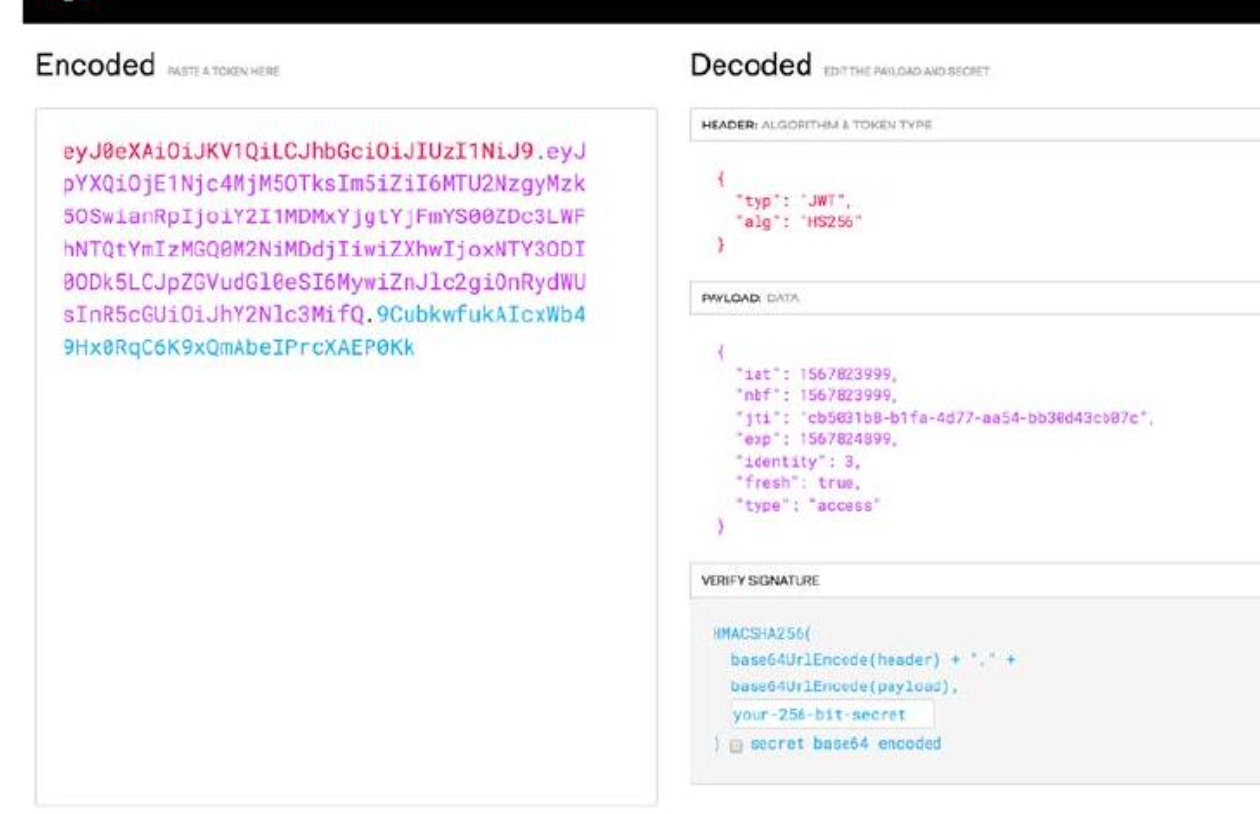

Avec une structure simple, header.payload.secret, nous avons un JWT, qui sera utilisé dans ce projet pour l'authentification des utilisateurs. En fonction de l'identité de l'utilisateur, nous pouvons ensuite appliquer des contrôles d'accès ou d'autres types de logique

## Flask-JWT-Extended

Flask-JWT-Extended est un package d'authentification utilisateur qui fournit la fonction create_access_token pour créer de nouveaux JWT d'accès. Il fournit également le décorateur jwt_required pour protéger les points de terminaison de l'API (pour vérifier si les utilisateurs se sont connectés). De plus, la fonction get_jwt_identity() est fournie pour obtenir l'identité d'un JWT dans un point de terminaison protégé. Cela nous permet de savoir qui sont les utilisateurs authentifiés. Il s'agit d'un package extrêmement utile pour l'authentification des utilisateurs. 

Avant de plonger dans l'exercice à venir, discutons d'abord de deux configurations de clés très importantes que nous utiliserons. Ils sont les suivants :

* SECRET_KEY : C'est la clé pour chiffrer le message et générer la signature. Nous vous recommandons d'utiliser une chaîne complexe.

* JWT_ERROR_MESSAGE_KEY : il s'agit de la clé du message d'erreur chaque fois qu'il y a une erreur. La valeur par défaut est msg, mais nous la réglons ici sur le message.


Nous travaillerons ensemble sur la fonction de connexion de l'utilisateur dans le prochain exercice. Vous apprendrez comment fonctionne la connexion de l'utilisateur et comment nous pouvons savoir qui est l'utilisateur authentifié

    
    Remarque
    
    Pour plus d'informations sur Flask-JWT-Extended, vous pouvez vous référer à
    ce lien : https://ask-jwt-extended.readthedocs.io/en/latest/options.html.

## Exercice 24 : Implémentation d'une fonction de connexion utilisateur

Dans cet exercice, nous allons créer la fonction de connexion utilisateur. Nous utiliserons le package Flask-JWT-Extended. Grâce à cet exercice, vous apprendrez comment générer des JWT dans Flask. Les utilisateurs entreront leurs informations d'identification dans http://localhost:5000/token et ils obtiendront un jeton. Ils peuvent ensuite utiliser ce jeton pour accéder à http://localhost:5000/users/{username} et vérifier leurs informations personnelles enregistrées dans le système. S'ils n'ont pas le jeton, ils ne verront que leur propre identifiant et leur nom d'utilisateur. C'est la fonction de contrôle d'accès de notre application Smilecook:

1. Installez le package Flask-JWT-Extended en ajoutant les lignes suivantes dans requirements.txt :


    Flask-JWT-Extended==3.20.0


2. Configurez Flask-JWT-Extended en ajoutant les paramètres suivants à la classe Config dans le fichier config.py le:

    SECRET_KEY = 'super-secret-key'
    JWT_ERROR_MESSAGE_KEY = 'message'

3. Mettez le code suivant dans extension.py :

    
    from flask_sqlalchemy import SQLAlchemy
    from flask_jwt_extended import JWTManager

    db = SQLAlchemy()
    jwt = JWTManager()

Ici, nous essayons de créer une instance de Flask-JWT-Extended. Nous importons d'abord la classe JWTManager depuis flask_jwt_extended, puis nous instancions une instance Flask-JWT-Extended en appelant JWTManager() et l'affectons à la variable jwt.

4. Tapez le code suivant dans app.py :


    from extensions import db, jwt
    
    def register_extensions(app):
        db.init_app(app)
        migrate = Migrate(app, db)
        jwt.init_app(app)


Nous avons d'abord importé jwt à partir des extensions, puis nous avons initialisé jwt avec jwt.init_app(app) dans register_extensions(app)

6. Nous allons maintenant créer la ressource pour la connexion. Nous allons d'abord créer le fichier token.py dans le dossier resources et taper le code suivant. Nous importons d'abord tous les modules, fonctions et classes nécessaires :


    from http import HTTPStatus
    from flask import request
    from flask_restful import Resource
    from flask_jwt_extended import create_access_token

    from utils import check_password
    from models.user import 

7. Ensuite, définissez une classe appelée TokenResource. Cette classe hérite de flask_restful.Resource

8. Dans la classe, nous créons une méthode post. Lorsqu'un utilisateur se connecte, cette méthode sera invoquée et prendra l'e-mail et le mot de passe de la demande JSON du client. Il utilisera la méthode get_by_email pour vérifier l'exactitude des informations d'identification de l'utilisateur :


    class TokenResource(Resource):

        def post(self):

            json_data = request.get_json()

            email = json_data.get('email')
            password = json_data.get('password')

            user = User.get_by_email(email=email)

            if not user or not check_password(password, user.password):
                return {'message': 'username or password is incorrect'}, HTTPStatus.UNAUTHORIZED

            access_token = create_access_token(identity=user.id)

            return {'access_token': access_token}, HTTPStatus.OK

S'ils ne sont pas valides, la méthode s'arrêtera là et renverra 401 UNAUTHORIZED, avec un message électronique indiquant que l'e-mail ou le mot de passe est incorrect. Sinon, il créera un jeton d'accès avec l'ID utilisateur comme identité de l'utilisateur.



**Remarque**

    La fonction check_password fonctionne en hachant le mot de passe que le
    client transmet et en comparant cette valeur de hachage avec celle stockée
    dans la base de données, à l'aide de la fonction pbkdf2_sha256.verify
    (password, hashed). Il n'y a pas de comparaison de mot de passe en texte clair ici.

9. Nous allons ensuite créer une nouvelle ressource, qui servira à obtenir les détails de l'utilisateur. Si l'utilisateur n'est pas authentifié, il ne peut voir que son identifiant et son nom d'utilisateur. Sinon, ils verront également leur e-mail personnel. Nous pouvons ajouter le code suivant à resources/user.py. Nous importons d'abord les modules, fonctions et classes nécessaires :


    from fask_jwt_extended import jwt_optional, get_jwt_identity

10. Ensuite, nous définissons une classe UserResource qui hérite de flask_restful.Resource:



    class UserResource(Resource):

11. Dans cette classe, nous définissons une méthode get et l'enveloppons avec un décorateur jwt_facultatif. Cela implique que le point de terminaison est accessible quelle que soit la procession du token:


    @jwt_optional    
    def get(self, username):
12. Nous effectuons ensuite une routine similaire à l'étape précédente et vérifions si le nom d'utilisateur peut être trouvé dans la base de données#


    user = User.get_by_username(username=username)
    if user is None:
        return {'message': 'user not found'}, HTTPStatus.NOT_FOUND

13. S'il est trouvé dans la base de données, nous vérifierons en outre s'il correspond à l'identité de l'ID utilisateur dans le JWT:


    current_user = get_jwt_identity()


14. En fonction du résultat de l'étape précédente, nous appliquons un contrôle d'accès et affichons différentes informations 


    class UserResource(Resource):

        @jwt_optional
        def get(self, username):

            user = User.get_by_username(username=username)

            if user is None:
                return {'message': 'user not found'}, HTTPStatus.NOT_FOUND

            current_user = get_jwt_identity()

            if current_user == user.id:
                data = {
                    'id': user.id,
                    'username': user.username,
                    'email': user.email,
                }

            else:
                data = {
                    'id': user.id,
                    'username': user.username,
                }

          return data, HTTPStatus.OK

15. Enfin, nous importerons les ressources que nous avons créées dans les étapes précédentes et les ajouterons à l'API dans app.py :


    from resources.user import UserListResource, UserResource
    from resources.token import TokenResource
    
    def register_resources(app):    
      api = Api(app) 

    api.add_resource(UserListResource, '/users')    
    api.add_resource(UserResource, '/users/<string:username>')    
    api.add_resource(TokenResource, '/token')

16. Faites un clic droit dessus pour exécuter l'application. Flask sera ensuite démarré et exécuté sur localhost (127.0.0.1) au port 5000

Nous avons donc terminé la fonction de connexion utilisateur. Cela permettra aux utilisateurs de visiter les API à accès contrôlé après la connexion. Testons-le dans notre prochain exercice !

## Exercice 25 : Test de la fonction de connexion utilisateur

Dans cet exercice, nous allons tester la fonction de connexion et vérifier les informations utilisateur stockées dans la base de données. Nous testerons également que les informations utilisateur obtenues à partir de l'API http://localhost:5000/users/{username} sont différentes avant et après la connexion utilisateur:

1. La première chose à faire est de créer un utilisateur. Cliquez sur l'onglet Collections et choisissez POST UserList.

2. Sélectionnez l'onglet Corps, sélectionnez le bouton radio brut et choisissez JSON (application/json) dans la liste déroulante. Saisissez les informations utilisateur suivantes (format JSON) dans le champ Body :

    
    {    
      "username": "james",    
      "email": "james@gmail.com",    
      "password": "WkQad19"
      }

3. Cliquez sur Envoyer pour vous inscrire. Le résultat est montré dans la capture d'écran suivante :

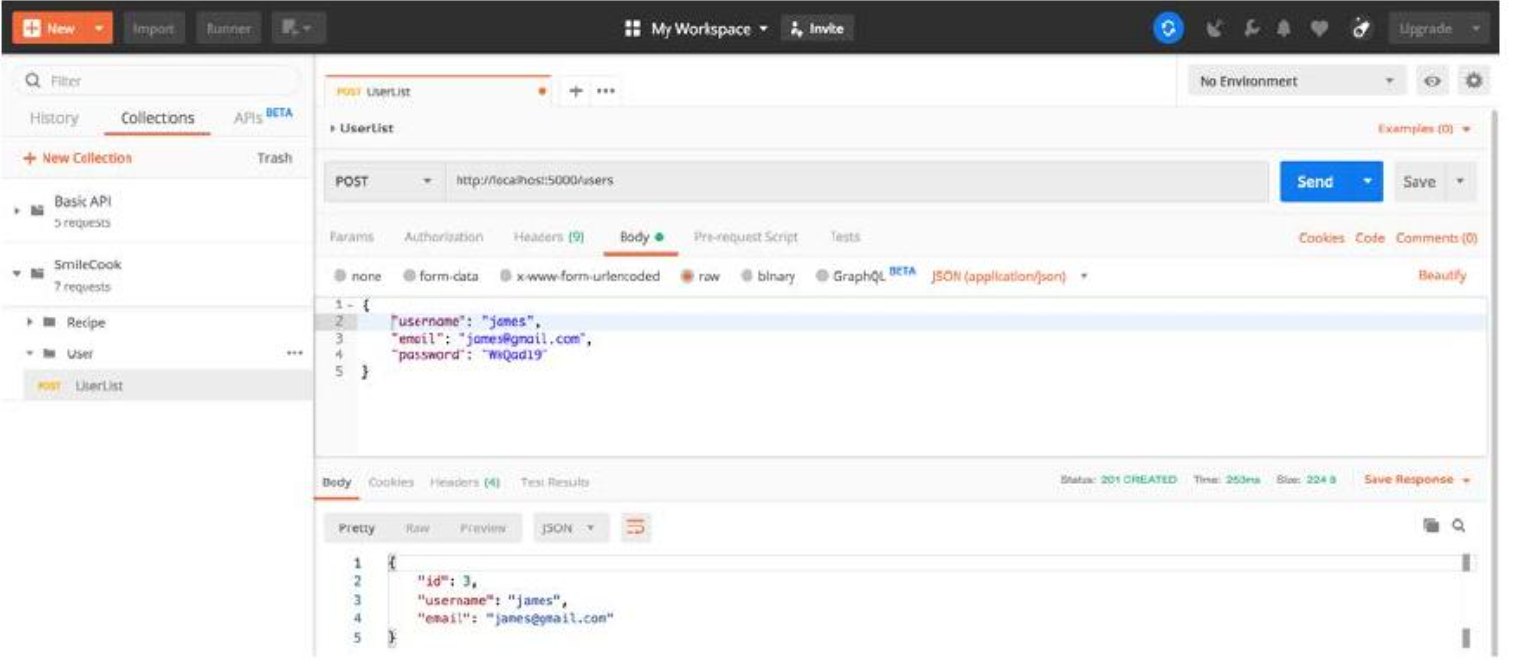

Vous verrez alors la réponse. Le statut HTTP est 201 CREATED, ce qui signifie que l'enregistrement de l'utilisateur a réussi. Et nous pouvons voir les détails de l'utilisateur dans le corps de la réponse. "id": 3 signifie ici que l'utilisateur est le troisième utilisateur enregistré avec succès.

4. Nous essaierons ensuite de vérifier les informations de l'utilisateur sans nous connecter. Voyons quelles informations nous pouvons obtenir. Cliquez sur l'onglet Collections, créez une nouvelle demande avec le nom User et enregistrez-la dans le dossier User.


5. Modifiez la demande et placez http://localhost:5000/users/james dans le champ URL. Enregistrez la demande afin qu'elle puisse être réutilisée ultérieurement.

6. Cliquez sur Envoyer pour obtenir les détails de l'utilisateur. Le résultat est montré dans la capture d'écran suivante :

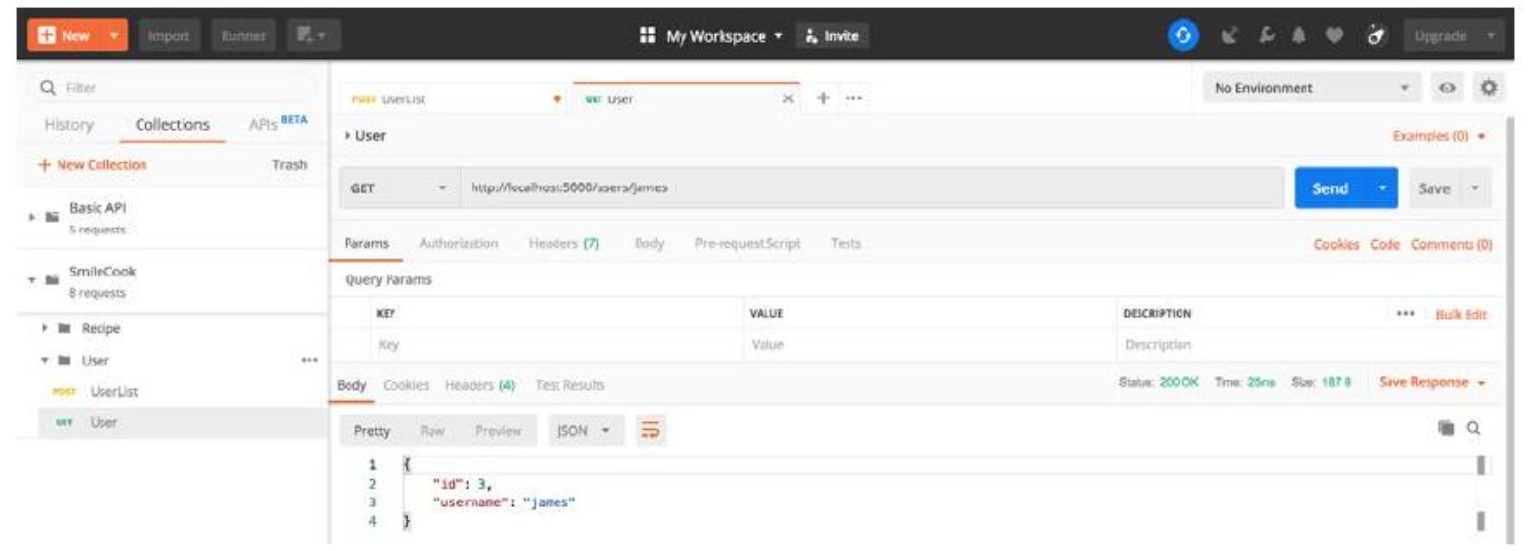

Vous verrez alors la réponse. Le statut HTTP est 200 OK, ce qui signifie que la demande a abouti. Nous pouvons voir l'ID et le nom d'utilisateur dans le corps de la réponse. Cependant, nous ne pouvons pas voir l'adresse e-mail ici car il s'agit d'informations privées et n'est visible que par l'utilisateur authentifié.

7. Maintenant, connectez-vous via l'API. Cliquez sur l'onglet Collections. Créez un nouveau dossier appelé Token et créez une nouvelle demande appelée Token à l'intérieur.

8. Modifiez la demande, changez la méthode en POST et placez http://localhost:5000/token dans le champ URL.

9. Cliquez sur l'onglet Body , cochez le bouton raw  radio et sélectionnez JSON (application/json) dans le menu déroulant. Saisissez le contenu JSON suivant dans le champ Body et cliquez sur Enregistrer :


    {    
      "email": "james@gmail.com",    
      "password": "WkQad19"
      }

10. Cliquez sur send pour vous connecter. Le résultat est affiché dans la capture d'écran suivante :


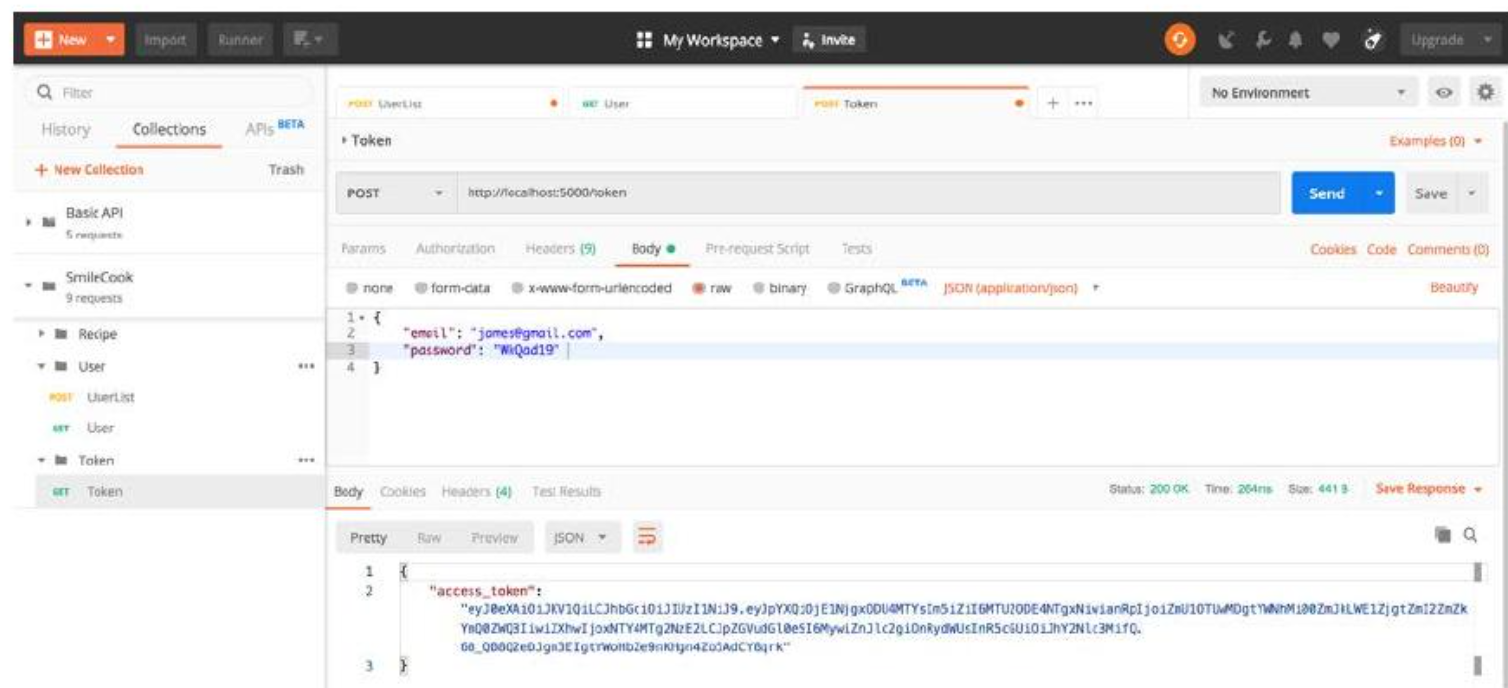

Vous verrez alors la réponse. Le code d'état HTTP 200 signifie que la connexion a réussi. Nous pouvons voir le jeton d'accès dans le corps de la réponse. Nous nous appuierons sur ce jeton pour montrer que l'utilisateur s'est connecté.

11. Maintenant, vérifiez à nouveau les informations de l'utilisateur après nous être connectés. Cliquez sur l'onglet Collections et sélectionnez la demande GET User.


12. Sélectionnez l'onglet Headers , sélectionnez Autorisation dans le champ KEY , tapez Bearer {token} dans le champ VALUE, où le jeton correspond à ce que nous avons obtenu à l'étape 10

13. Cliquez sur Envoyer pour obtenir les détails de l'utilisateur. Le résultat est montré dans la capture d'écran suivante :

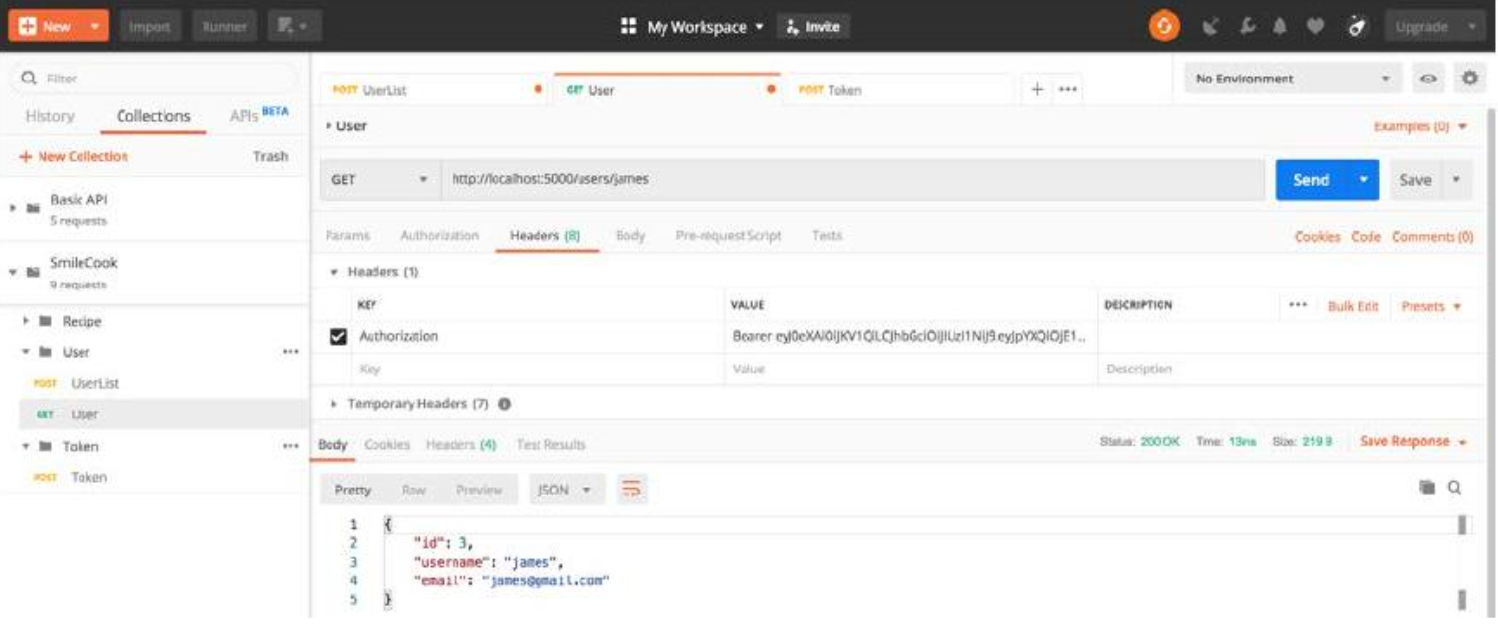

Vous verrez alors la réponse, le code d'état HTTP 200 signifie que la requête est réussie. Et dans le corps de la réponse, nous pouvons voir des informations, notamment l'identifiant, le nom d'utilisateur et l'e-mail.

Dans cet exercice, nous pouvons voir comment fonctionne réellement le contrôle d'accès. Nous pouvons voir la différence dans la réponse HTTP avant et après l'authentification de l'utilisateur. Ceci est très important pour notre application Smilecook car nous voulons protéger la vie privée de nos utilisateurs. Il existe des informations que seuls certains utilisateurs authentifiés peuvent voir.

## Exercice 26 : Création du point de terminaison

Dans cet exercice, nous allons créer un point de terminaison spécial, /users/me. Cela nous permettra de récupérer les informations de l'utilisateur authentifié en utilisant access_token. Nous allons d'abord créer une nouvelle classe de ressources sous le modèle utilisateur. Il y aura une méthode get dedans, et nous l'associerons finalement au nouveau point de terminaison de l'API :



1. Ajoutez la méthode get_by_id dans models/user.py. Pour des raisons de commodité, nous utiliserons cette méthode pour obtenir l'objet utilisateur par ID :


    @classmethod 
    def get_by_id(cls, id):                 
      return cls.query.filter_by(id=id).first()

2. Dans resources/user.py, importez jwt_required et créez une classe MeResource :


    from flask_jwt_extended import jwt_optional, get_jwt_identity, jwt_required

    class MeResource(Resource):

        @jwt_required
        def get(self):
            user = User.get_by_id(id=get_jwt_identity())

            data = {
                'id': user.id,
                'username': user.username,
                'email': user.email,
            }

            return data, HTTPStatus.OK

La méthode get ici obtiendra les informations de l'utilisateur par l'ID dans le JWT.


3. Dans app.py, importez la classe MeResource. Ajoutez le point de terminaison /me :


    from resources.user import UserListResource, UserResource, MeResource
    
    api.add_resource(MeResource, '/me')

4. Faites un clic droit dessus pour exécuter l'application. Flask sera ensuite démarré et exécuté sur localhost (127.0.0.1) au port 5000 

5. Maintenant, vérifiez à nouveau les informations de l'utilisateur après nous être connectés à l'aide du point de terminaison users/me. Cliquez sur l'onglet Collections et créez une nouvelle demande appelée me dans le dossier User.

6. Mettez http://localhost:5000/me dans le champ URL.


7. Sélectionnez l'onglet Headers , sélectionnez Autorisation dans le champ KEY  et saisissez Bearer {token} dans le champ VALUE, où le jeton correspond à ce que nous avons obtenu dans l'exercice précédent.

8. Cliquez sur Envoyer pour obtenir les détails de l'utilisateur. Le résultat est montré dans la capture d'écran suivante :

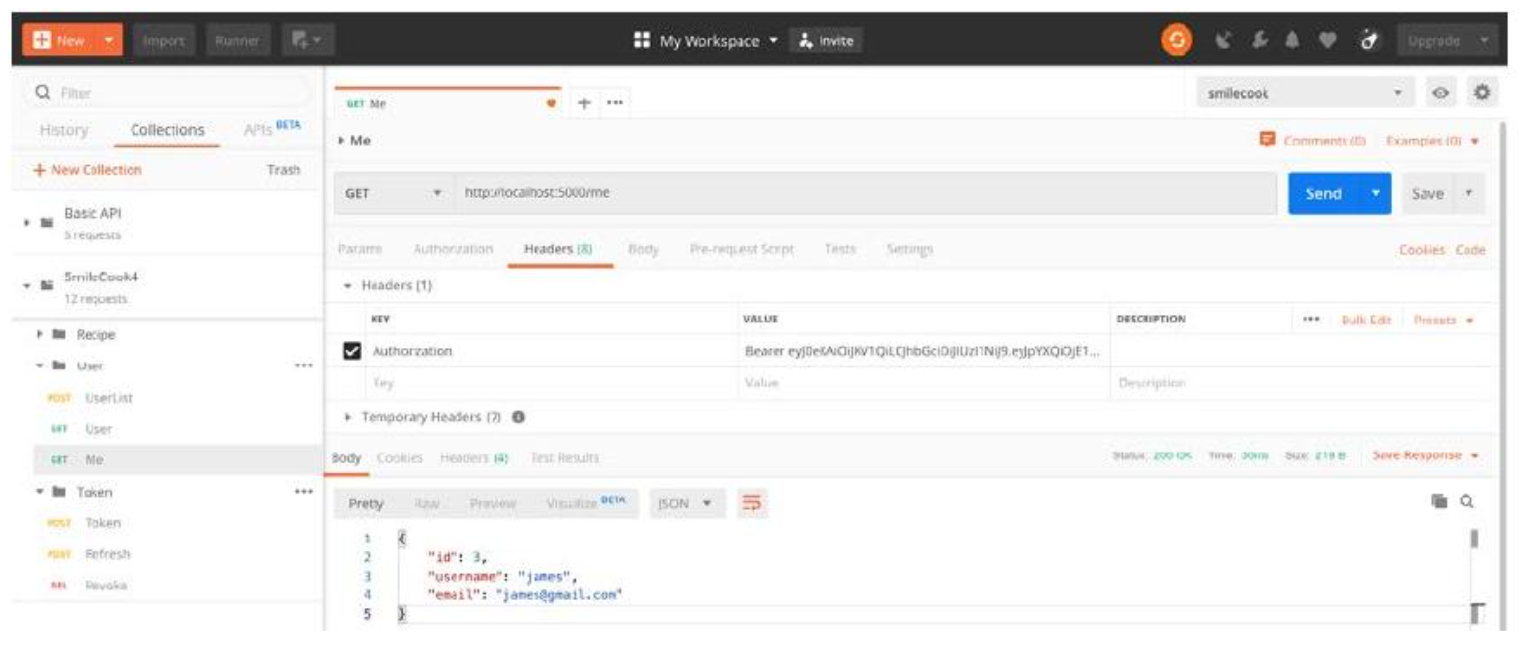

Ce nouveau point de terminaison d'API nous permet d'obtenir les informations utilisateur authentifiées simplement en utilisant le jeton d'accès. Cela signifie que chaque fois que l'utilisateur est dans l'état authentifié, nous pouvons obtenir ses informations. Maintenant que nous avons à peu près identifié les utilisateurs, passons aux recettes.

## Concevoir les méthodes dans le modèle de recette

Maintenant, nous avons terminé la fonction d'enregistrement et de connexion de l'utilisateur, nous allons travailler sur les fonctionnalités de gestion de recette de notre application Smilecook. Cela nécessitera quelques méthodes dans la classe Recipe pour faire le travail. Dans notre conception, nous aurons les cinq méthodes suivantes : 

* data : elles sont utilisées pour renvoyer les données dans un format de dictionnaire. 
* get_all_published : cette méthode récupère toutes les recettes publiées.
* get_by_id : cette méthode récupère les recettes par ID.
* save : cette méthode conserve les données dans la base de données.
* ,delete : cette méthode supprime les données de la base de données. 

Ces cinq méthodes couvrent à peu près toutes les fonctions nécessaires à la gestion des recettes. Dans le prochain exercice, nous travaillerons sur l'implémentation de ces méthodes dans notre application Smilecook.


## Exercice 27 : Implémentation de fonctions de gestion de recettes à accès contrôlé

Le but de cet exercice est d'implémenter différentes fonctions de gestion de recettes sur notre plateforme afin que les utilisateurs puissent gérer leurs propres recettes dans notre application Smilecook. Nous devrons également modifier RecipeListResource et RecipeResource pour y restreindre l'accès à certaines méthodes :



1. Dans models/recipe.py, ajoutez les méthodes data, get_all_published, get_by_id, save et delete à la classe Recipe :


    from extensions import db


    class Recipe(db.Model):
        __tablename__ = 'recipe'

        id = db.Column(db.Integer, primary_key=True)
        name = db.Column(db.String(100), nullable=False)
        description = db.Column(db.String(200))
        num_of_servings = db.Column(db.Integer)
        cook_time = db.Column(db.Integer)
        directions = db.Column(db.String(1000))
        is_publish = db.Column(db.Boolean(), default=False)
        created_at = db.Column(db.DateTime(), nullable=False, server_default=db.func.now())
        updated_at = db.Column(db.DateTime(), nullable=False, server_default=db.func.now(), onupdate=db.func.now())

        user_id = db.Column(db.Integer(), db.ForeignKey("user.id"))

        def data(self):
            return {
                'id': self.id,
                'name': self.name,
                'description': self.description,
                'num_of_servings': self.num_of_servings,
                'cook_time': self.cook_time,
                'directions': self.directions,
                'user_id': self.user_id
            }

        @classmethod
        def get_all_published(cls):
            return cls.query.filter_by(is_publish=True).all()

        @classmethod
        def get_by_id(cls, recipe_id):
            return cls.query.filter_by(id=recipe_id).first()

        def save(self):
            db.session.add(self)
            db.session.commit()

        def delete(self):
            db.session.delete(self)
            db.session.commit()

2. Supprimez le code suivant dans models/recipe.py :




    recipe_list = []  
    
    def get_last_id():    
    
    if recipe_list:        
      last_recipe = recipe_list[-1]    
    
    else:        
      return 1    
      
    return last_recipe.id + 1

3. Dans resources/recipe.py, importez get_jwt_identity, jwt_required et jwt_facultatif :


    rom fask_jwt_extended import get_jwt_identity, jwt_required, jwt_optional

4. Supprimer l'importation de la liste de recettes


    from models.recipe import Recipe

5. Nous allons ensuite modifier la méthode get dans la classe RecipeListResource. Nous obtiendrons toutes les recettes publiées en déclenchant Recipe.get_all_published(). Ensuite, dans la boucle for, il parcourt la liste des recettes, convertit chaque recette en un objet dictionnaire et renvoie la liste des dictionnaires :


    class RecipeListResource(Resource):

        def get(self):

            recipes = Recipe.get_all_published()

            data = []

            for recipe in recipes:
                data.append(recipe.data())

            return {'data': data}, HTTPStatus.OK


6. Nous continuons ensuite à modifier la méthode post dans la classe RecipeListResource. Le décorateur @jwt_required indique ici que la méthode ne peut être invoquée qu'une fois que l'utilisateur s'est connecté. À l'intérieur de la méthode, il obtient tous les détails de la recette des demandes du client et les enregistre dans la base de données. Enfin, il renverra les données avec un code d'état HTTP de 201 CREATED :


    @jwt_required
    def post(self):
        json_data = request.get_json()

        current_user = get_jwt_identity()

        recipe = Recipe(name=json_data['name'],
                        description=json_data['description'],
                        num_of_servings=json_data['num_of_servings'],
                        cook_time=json_data['cook_time'],
                        directions=json_data['directions'],
                        user_id=current_user)

        recipe.save()

        return recipe.data(), HTTPStatus.CREATED


7. Nous allons modifier la méthode get dans RecipeResource pour obtenir une recette spécique. Le décorateur @jwt_optionnel spécifie que le JWT est facultatif. Dans la méthode, nous utilisons Recipe.get_by_id(recipe_id=recipe_id) pour obtenir la recette. Si la recette spécifique n'est pas trouvée, nous renverrons 404 NOT_FOUND. S'il est trouvé, nous changerons alors l'utilisateur qui possède la recette et le statut. Il y a un contrôle d'accès ici, il renverra donc 403 INTERDIT ou 200 OK selon la situation :



    class RecipeResource(Resource):

    @jwt_optional
    def get(self, recipe_id):

        recipe = Recipe.get_by_id(recipe_id=recipe_id)

        if recipe is None:
            return {'message': 'Recipe not found'}, HTTPStatus.NOT_FOUND

        current_user = get_jwt_identity()

        if recipe.is_publish == False and recipe.user_id != current_user:
            return {'message': 'Access is not allowed'}, HTTPStatus.FORBIDDEN

        return recipe.data(), HTTPStatus.OK

8. Nous allons modifier la méthode put dans RecipeResource pour obtenir une recette spécique. Cette méthode put consiste à mettre à jour les détails de la recette. Il vérifiera d'abord si la recette existe et si l'utilisateur dispose des privilèges de mise à jour. Si tout va bien, il mettra à jour les détails de la recette et l'enregistrera dans la base de données :


    @jwt_required
    def put(self, recipe_id):

        json_data = request.get_json()

        recipe = Recipe.get_by_id(recipe_id=recipe_id)

        if recipe is None:
            return {'message': 'Recipe not found'}, HTTPStatus.NOT_FOUND

        current_user = get_jwt_identity()

        if current_user != recipe.user_id:
            return {'message': 'Access is not allowed'}, HTTPStatus.FORBIDDEN

        recipe.name = json_data['name']
        recipe.description = json_data['description']
        recipe.num_of_servings = json_data['num_of_servings']
        recipe.cook_time = json_data['cook_time']
        recipe.directions = json_data['directions']

        recipe.save()

        return recipe.data(), HTTPStatus.OK

9. Nous allons modifier la méthode de suppression dans RecipeResource pour obtenir une recette spécifique. C'est pour supprimer une recette. Le décorateur @jwt_required implique que le JWT est requis. Lorsque l'utilisateur s'est connecté, il peut accéder à ce chemin et supprimer la recette spéciée si elle existe :


    @jwt_required
    def delete(self, recipe_id):

        recipe = Recipe.get_by_id(recipe_id=recipe_id)

        if recipe is None:
            return {'message': 'Recipe not found'}, HTTPStatus.NOT_FOUND

        current_user = get_jwt_identity()

        if current_user != recipe.user_id:
            return {'message': 'Access is not allowed'}, HTTPStatus.FORBIDDEN

        recipe.delete()

        return {}, HTTPStatus.NO_CONTENT


Ainsi, dans cet exercice, nous avons implémenté les fonctions de gestion des recettes et ajouté le contrôle d'accès aux ressources. Désormais, seuls les utilisateurs autorisés sont autorisés à gérer leurs recettes. 




## Actualiser les jetons

Pour des raisons de sécurité, nous fixons souvent un délai d'expiration pour nos jetons (flask-jwt-extended par défaut à 15 minutes). Étant donné qu'un jeton expirera, nous avons besoin d'une fonction pour l'actualiser sans que les utilisateurs ne ressaisissent leurs informations d'identification. Flask-JWT-Extended fournit des fonctions d'actualisation liées au jeton. 

Un jeton d'actualisation est un jeton de longue durée qui peut être utilisé pour générer de nouveaux jetons d'accès. Veuillez ne pas mélanger les jetons d'actualisation et les jetons d'accès. Un jeton d'actualisation ne peut être utilisé que pour obtenir un nouveau jeton d'accès ; il ne peut pas être utilisé comme jeton d'accès pour accéder aux points de terminaison restreints. Par exemple, les points de terminaison qui ont les décorateurs jwt_required() ou jwt_optional ont besoin d'un jeton d'accès.


Voici une brève explication des fonctions liées au jeton d'actualisation dans Flask-JWT-Extended :

* create_access_token : cette fonction crée un nouveau jeton d'accès.
* create_refresh_token : cette fonction crée un jeton d'actualisation.
* jwt_refresh_token_required : il s'agit d'un décorateur spécifiant que le jeton d'actualisation est requis. 
* get_jwt_identity : cette fonction obtient l'utilisateur qui détient le jeton d'accès actuel. 

Vous en apprendrez plus sur ces fonctions dans le prochain exercice. Nous allons également ajouter un nouvel attribut fresh  à notre jeton. Ce fresh  attribut ne sera défini sur True que lorsque les utilisateurs obtiendront le jeton en saisissant leurs informations d'identification. Lorsqu'ils actualisent simplement le jeton, ils obtiendront un jeton avec fresh = false. La raison d'un jeton d'actualisation est que nous souhaitons éviter que les utilisateurs n'aient à saisir leurs informations d'identification encore et encore. Cependant, pour certaines fonctions critiques, par exemple la modification des mots de passe, nous leur demanderons toujours d'avoir un nouveau jeton.





## Exercice 29 : Ajout d'une fonction de jeton d'actualisation

Dans cet exercice, nous allons ajouter une fonction de jeton d'actualisation à notre application Smilecook afin que lorsque le jeton d'accès de l'utilisateur expire, il puisse utiliser le jeton d'actualisation pour obtenir un nouveau jeton d'accès:

* 1. Dans resources/token.py, importez les fonctions nécessaires depuis flask_jwt_extended :


    from fask_jwt_extended import (    
      create_access_token,    
      create_refresh_token,    
      jwt_refresh_token_required,    
      get_jwt_identity)

2. Modifiez la méthode post sous TokenResource pour générer un jeton et un refresh_token pour l'utilisateur :


    class TokenResource(Resource):

        def post(self):

            json_data = request.get_json()

            email = json_data.get('email')
            password = json_data.get('password')

            user = User.get_by_email(email=email)

            if not user or not check_password(password, user.password):
                return {'message': 'username or password is incorrect'}, HTTPStatus.UNAUTHORIZED

            access_token = create_access_token(identity=user.id, fresh=True)
            refresh_token = create_refresh_token(identity=user.id)

            return {'access_token': access_token, 'refresh_token': refresh_token}, HTTPStatus.OK



Nous passons le paramètre fresh=True à la fonction create_access_token. Nous invoquons ensuite la fonction create_refresh_token pour générer un jeton d'actualisation.


3. Ajoutez la classe RefreshResource à token.py. Veuillez ajouter le code suivant :


    class RefreshResource(Resource):

        @jwt_refresh_token_required
        def post(self):
            current_user = get_jwt_identity()

            token = create_access_token(identity=current_user, fresh=False)

            return {'token': token}, HTTPStatus.OK

Le décorateur @jwt_refresh_token_required spécifie que ce point de terminaison nécessitera un jeton d'actualisation. Dans cette méthode, nous générons un jeton pour l'utilisateur avec fresh=false.



4. Enfin, ajoutez la route pour RefreshResource :


    from resources.token import TokenResource, RefreshResource
    
    def register_resources(app):    
        api.add_resource(RefreshResource, '/refresh')

5. Enregistrez app.py et faites un clic droit dessus pour exécuter l'application. Flask sera ensuite démarré et exécuté sur localhost (127.0.0.1) au port 5000 

Toutes nos félicitations! Nous venons d'ajouter la fonction de jeton de rafraîchissement. Passons à la partie test.

## Exercice 30 : Obtention d'un nouveau jeton d'accès à l'aide d'un jeton d'actualisation

Dans cet exercice, nous utiliserons Postman pour nous connecter au compte utilisateur et obtenir le jeton d'accès et le jeton d'actualisation. Plus tard, nous obtiendrons un nouveau jeton d'accès en utilisant le jeton de rafraîchissement. Il s'agit de simuler un scénario réel dans lequel nous souhaitons garder l'utilisateur connecté :


1. Nous allons d'abord tester la journalisation. Cliquez sur l'onglet Collections. Sélectionnez la demande de jeton POST que nous avons créée précédemment.

2. Cochez le bouton radio raw et sélectionnez JSON (application/json) dans le menu déroulant.

3. Ajoutez le contenu JSON suivant dans le champ Body :

        {
          "email": "james@gmail.com",    
          "password": "WkQad19"
        }

4. Cliquez sur Envoyer pour vous connecter au compte. Le résultat est montré dans la capture d'écran suivante

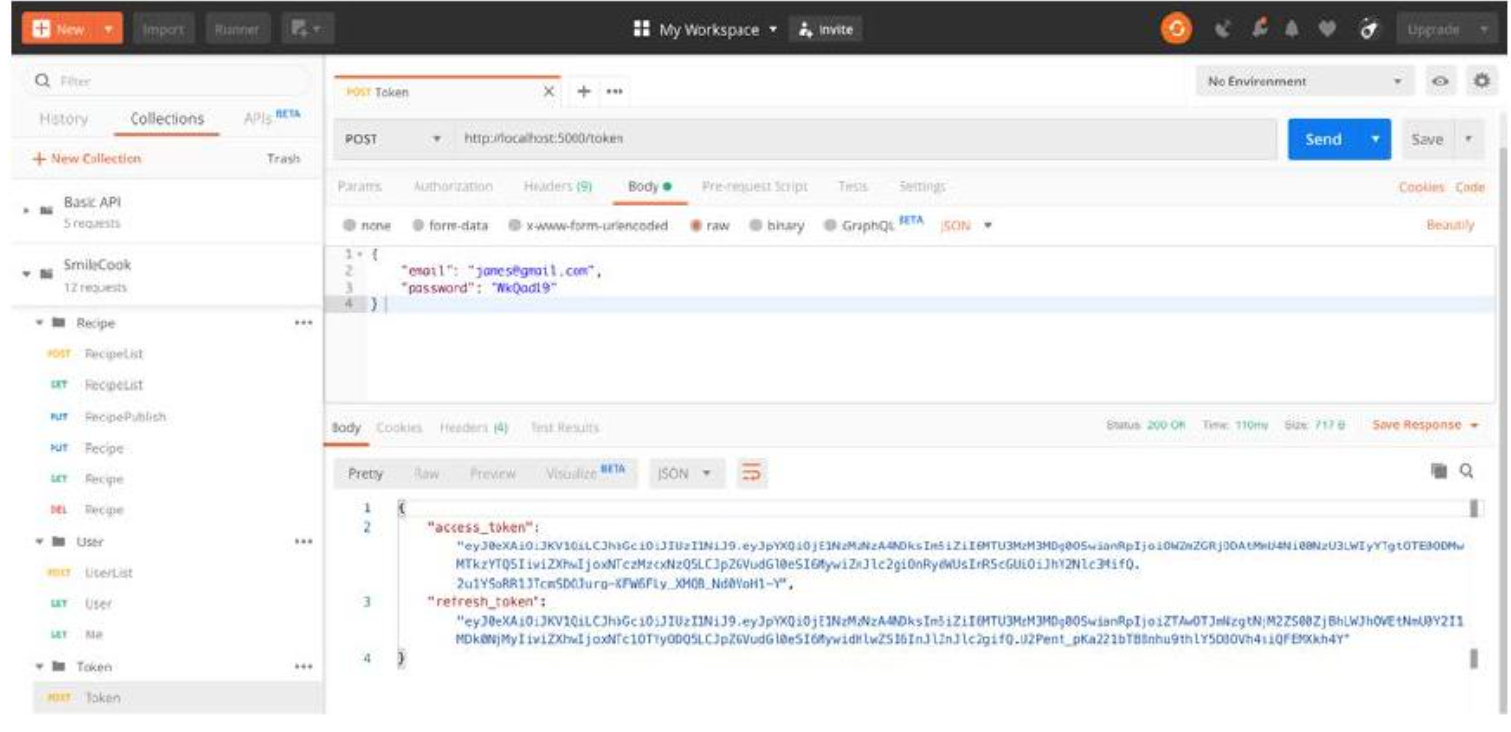

Nous pouvons voir que le code d'état HTTP est 200 OK, ce qui signifie que la connexion a réussi. Nous pouvons également voir le jeton d'accès et le jeton d'actualisation dans le corps


5. Ensuite, nous obtiendrons le jeton d'accès en utilisant le jeton d'actualisation. Cliquez sur l'onglet Collections. Créez une nouvelle demande, nommez-la refresh  et enregistrez-la dans le dossier Token.

6. Sélectionnez cette nouvelle demande et choisissez POST comme méthode. Mettez http://localhost:5000/refresh dans le champ URL.

7. Accédez à l'onglet Headers  et sélectionnez Authorization  dans le champ KEY et Bearer {token} dans le champ VALUE, où le jeton est le JWT obtenu à l'étape 4

8. Cliquez sur Envoyer pour actualiser le jeton. Le résultat est montré dans la capture d'écran suivante :

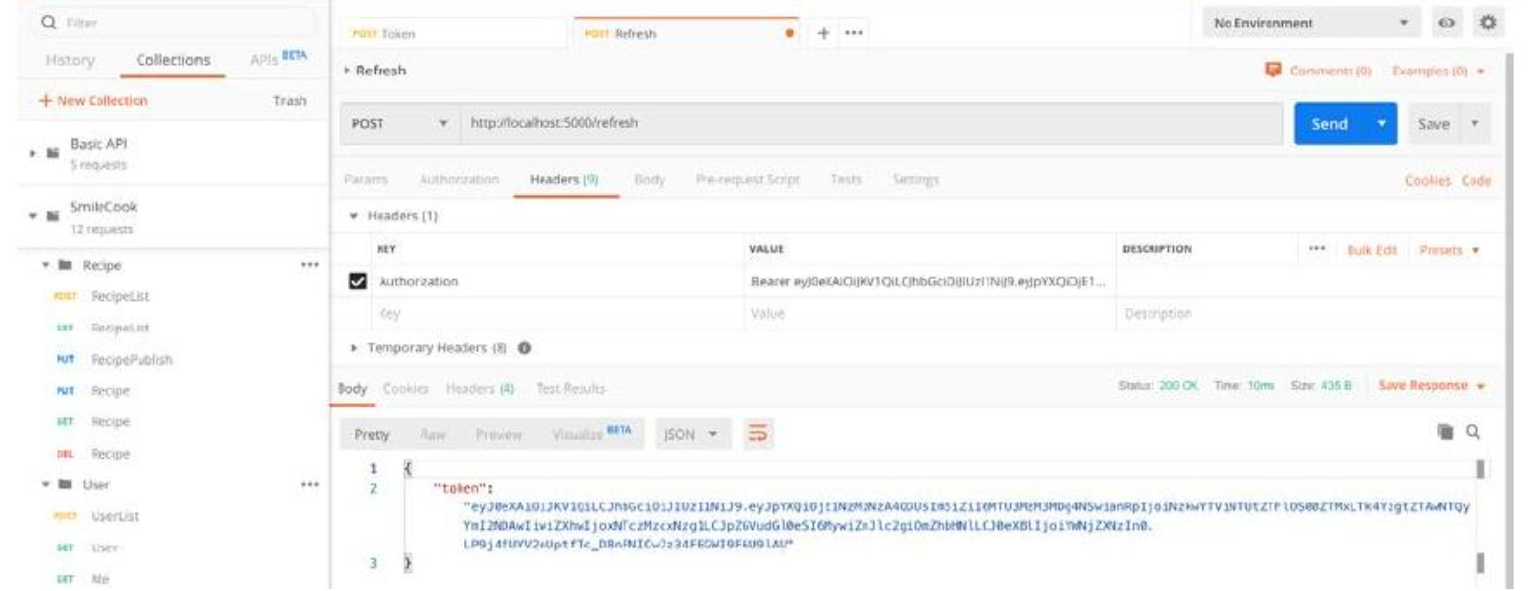

Nous pouvons voir le statut HTTP 200 OK, ce qui signifie que la demande a été réussie. Et nous pouvons voir le nouveau jeton d'accès dans le corps de la réponse. Si le jeton d'accès expire à l'avenir, nous pouvons utiliser un jeton d'actualisation pour obtenir un nouveau jeton d'accès.

## Le mécanisme de déconnexion de l'utilisateur 

Le package Flask-JWT-Extended prend en charge la fonction de déconnexion. La façon dont cela fonctionne est de mettre le jeton dans une liste noire lorsque l'utilisateur est déconnecté. Une liste noire est essentiellement une liste de blocage ; c'est un mécanisme de contrôle d'accès. Les éléments (par exemple, les e-mails, les jetons, les identifiants, etc.) sur la liste se verront refuser l'accès. Une fois la liste noire en place, l'application peut utiliser token_in_blacklist_loader pour vérifier si l'utilisateur s'est déconnecté ou non :

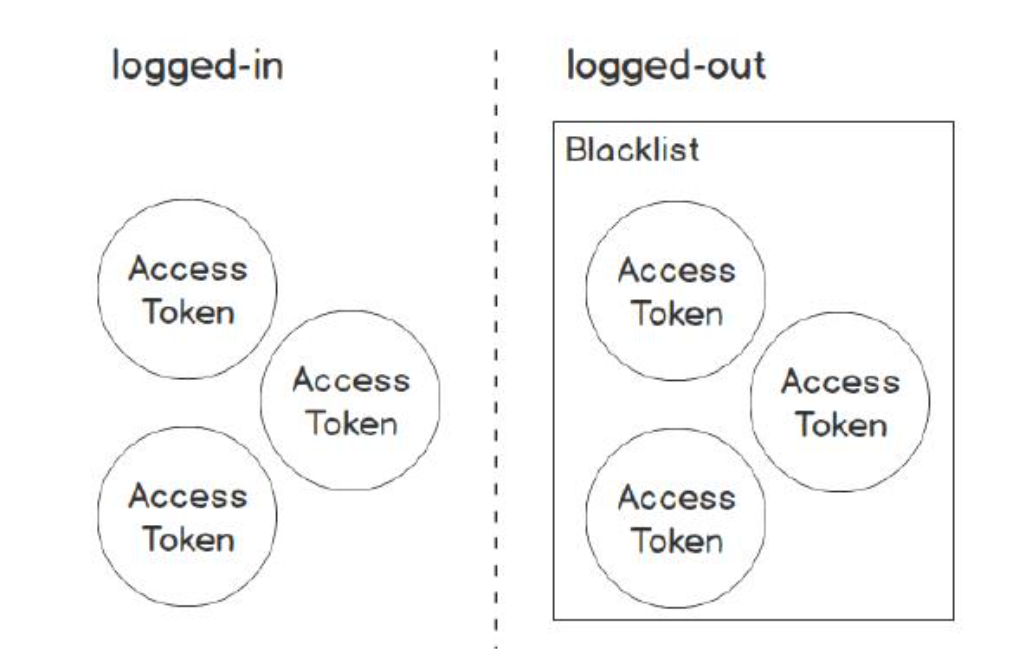

Dans l'exercice suivant, nous souhaitons que vous essayiez d'implémenter cette fonction de déconnexion. Il testera votre compréhension du flux de connexion et de déconnexion.

## Exercice 31 : Implémentation de la fonction de déconnexion 

Dans cet exercice, nous allons implémenter la fonction de déconnexion. Nous allons d'abord déclarer une black_list pour stocker tous les jetons d'accès déconnectés. Plus tard, lorsque l'utilisateur souhaite visiter les points de terminaison de l'API à accès contrôlé, nous allons d'abord vérifier si le jeton d'accès est toujours valide à l'aide de la liste noire :


1. Importez get_raw_jwt. Dans resources/token.py, nous importerons jwt_required et get_raw_jwt depuis flask_jwt_extended :

    
    from fask_jwt_extended import (    
      create_access_token,    
      create_refresh_token,    
      jwt_refresh_token_required,    
      get_jwt_identity,    
      jwt_required,    
      get_raw_jwt)


2. Dans resources/token.py, affectez set() à black_list :

black_list = set()


3. Créez la classe RevokeResource et définissez la méthode post. Nous appliquerons ici le décorateur @jwt_required pour contrôler l'accès à ce point de terminaison. Dans cette méthode, nous obtenons le jeton en utilisant get_raw_jwt()['jti'] et le mettons dans la liste noire :


    class RevokeResource(Resource):

        @jwt_required
        def post(self):
            jti = get_raw_jwt()['jti']

            black_list.add(jti)

            return {'message': 'Successfully logged out'}, HTTPStatus.OK


4. Nous ajouterons ensuite le code suivant dans config.py. Comme vous pouvez le constater, nous activons la fonction de liste noire et demandons également à l'application de vérifier à la fois le jeton d'accès et d'actualisation :


      JWT_BLACKLIST_ENABLED = True
      JWT_BLACKLIST_TOKEN_CHECKS = ['access', 'refresh']

5. Nous importerons ensuite RevokeResource et black_list dans app.py :


    from resources.token import TokenResource, RefreshResource, RevokeResource, black_list


6. Ensuite, à l'intérieur de register_extensions(app), nous ajouterons les lignes de code suivantes. Il s'agit de vérifier si le token est sur la liste noire :


    def register_extensions(app):
        db.init_app(app)
        migrate = Migrate(app, db)
        jwt.init_app(app)

        @jwt.token_in_blacklist_loader
        def check_if_token_in_blacklist(decrypted_token):
            jti = decrypted_token['jti']
            return jti in black_list


7. . Enfin, ajoutez la route dans register_resources :


    def register_resources(app):    
    api.add_resource(TokenResource, '/token')    
    api.add_resource(RefreshResource, '/refresh')    
    api.add_resource(RevokeResource, '/revoke')

8. Enregistrez app.py et faites un clic droit dessus pour exécuter l'application. Flask sera ensuite démarré et exécuté sur localhost (127.0.0.1) au port 5000 :

## Exercice 32 : Test de la fonction de déconnexion 

Dans cet exercice, nous allons tester la fonction de déconnexion que nous venons d'implémenter dans l'exercice précédent. Une fois que nous nous sommes déconnectés, nous essaierons d'accéder à un point de terminaison à accès contrôlé et nous nous assurerons que nous n'y avons plus accès:

1. Nous allons nous déconnecter de notre application. Cliquez sur l'onglet Collections et créez une nouvelle demande, nommez-la Revoke et enregistrez-la dans le dossier Token.

2. Sélectionnez cette nouvelle demande et choisissez POST comme méthode. Mettez http://localhost:5000/revoke dans le champ URL.

3. Accédez à l'onglet Headers . Sélectionnez Authorization  dans le champ KEY et Bearer {token} dans le champ VALUE, où le token est le JWT que nous avons obtenu dans l'exercice précédent.

4. Cliquez sur Envoyer pour vous déconnecter. Le résultat est montré dans la capture d'écran suivante :

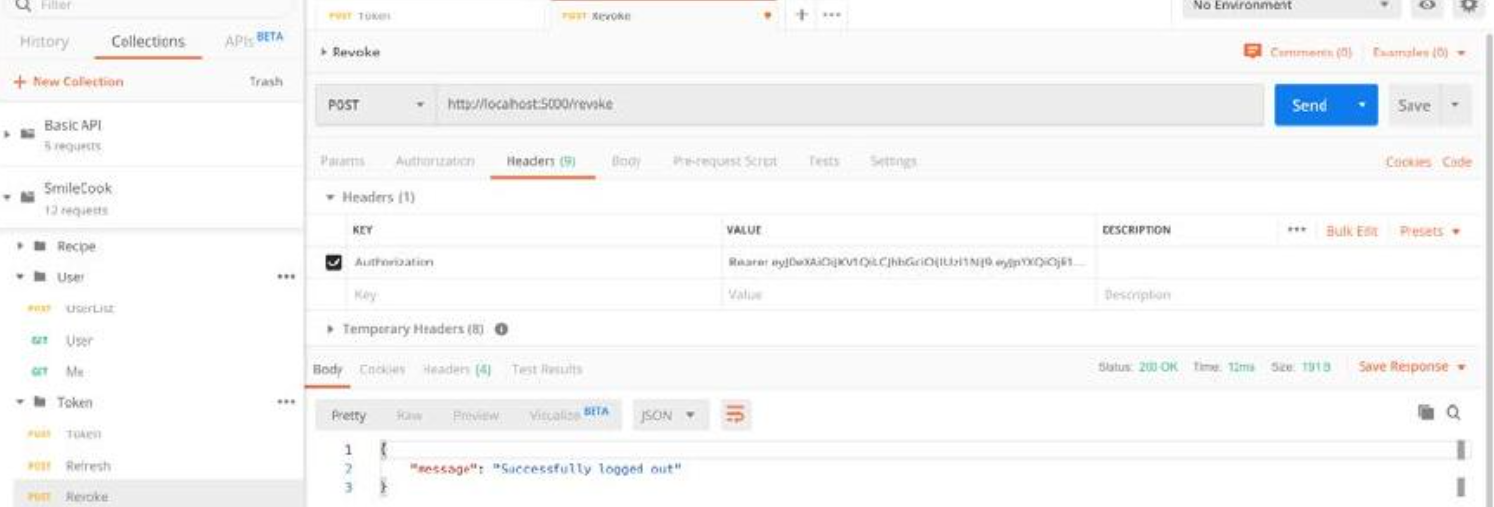

Vous verrez alors la réponse HTTP status 200 OK, ce qui signifie que l'utilisateur s'est déconnecté avec succès. En plus de cela, nous pouvons également voir le message indiquant que l'utilisateur s'est déconnecté avec succès.

5. Déconnectez-vous à nouveau et voyez ce qui se passe. Cliquez à nouveau sur Envoyer et vous verrez alors la réponse suivante :

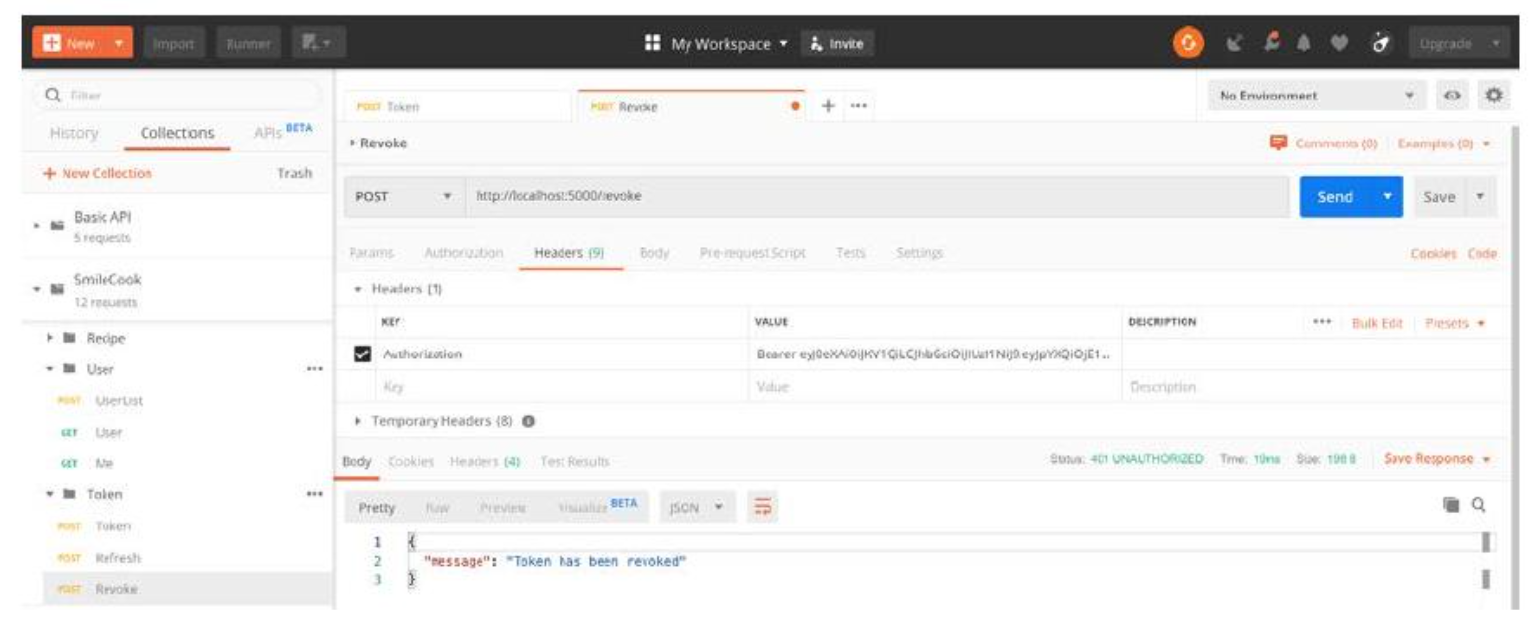

Nous pouvons voir le statut HTTP 401 UNAUTHORIZED, ce qui signifie que l'utilisateur n'a pas accès à ce point de terminaison car le jeton d'accès d'origine a déjà été placé sur la liste noire. Dans le corps de la réponse, nous pouvons voir le message Token a été révoqué, ce qui signifie que l'utilisateur s'est déconnecté avec succès

Résumé
Dans ce guide, nous avons appris à utiliser Flask-JWT-Extended pour le contrôle d'accès. Il s'agit d'une caractéristique importante et fondamentale dont presque toutes les plateformes en ligne auront besoin. À la fin du guide, nous avons abordé le sujet du maintien de la vivacité d'un jeton. Il s'agit de connaissances avancées mais applicables que vous utiliserez pour développer des API RESTful réelles. 